In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

print("Path to dataset files:", '/content/drive/MyDrive/graphic/Face Mask.zip')

100%|██████████| 163M/163M [00:09<00:00, 18.7MB/s]

Extracting files...


Path to dataset files: /content/drive/MyDrive/graphic/Face Mask.zip


In [ ]:

import os
import zipfile
from tqdm import tqdm
import pandas as pd

# Specify the path to your zip file
zip_file_path = '/content/drive/MyDrive/graphic/Face Mask.zip'

# Specify the directory where you want to extract the contents
extract_dir = '/content/Face_Mask_Dataset/data'  # Choose a suitable directory

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile('/content/drive/MyDrive/graphic/Face Mask.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Now you can list the contents of the extracted directory
images = []
labels = []
for subfolder in tqdm(os.listdir('/content/Face_Mask_Dataset/data/data')):
    subfolder_path = os.path.join('/content/Face_Mask_Dataset/data/data', subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)

df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 2/2 [00:00<00:00, 163.20it/s]


image         label
0     /content/Face_Mask_Dataset/data/data/with_mask...     with_mask
1     /content/Face_Mask_Dataset/data/data/with_mask...     with_mask
2     /content/Face_Mask_Dataset/data/data/with_mask...     with_mask
3     /content/Face_Mask_Dataset/data/data/with_mask...     with_mask
4     /content/Face_Mask_Dataset/data/data/with_mask...     with_mask
...                                                 ...           ...
7548  /content/Face_Mask_Dataset/data/data/without_m...  without_mask
7549  /content/Face_Mask_Dataset/data/data/without_m...  without_mask
7550  /content/Face_Mask_Dataset/data/data/without_m...  without_mask
7551  /content/Face_Mask_Dataset/data/data/without_m...  without_mask
7552  /content/Face_Mask_Dataset/data/data/without_m...  without_mask

[7553 rows x 2 columns]

<ipython-input-7-9cac260aa318>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df.label, palette="viridis")  # Change the palette here


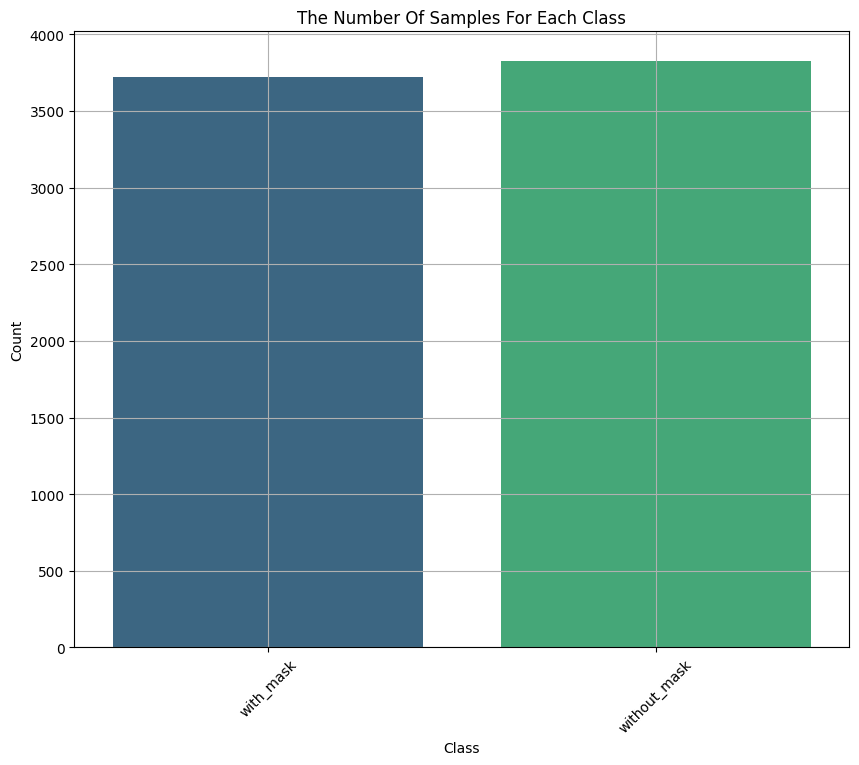

In [ ]:
plt.figure(figsize=(10, 8))
ax = sns.countplot(x=df.label, palette="viridis")  # Change the palette here
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.title('The Number Of Samples For Each Class')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [ ]:
X_train, X_test1, y_train, y_test1 = train_test_split(df['image'], df['label'], test_size=0.3, random_state=42,shuffle=True,stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [ ]:
image_size = (224,224)
batch_size = 64
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 5287 validated image filenames belonging to 2 classes.
Found 1133 validated image filenames belonging to 2 classes.
Found 1133 validated image filenames belonging to 2 classes.


In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
model=keras.models.Sequential()
model.add(base_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(2,activation=tf.nn.softmax))
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      16,056,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,315,074 (69.87 MB)

 Trainable params: 16,057,090 (61.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

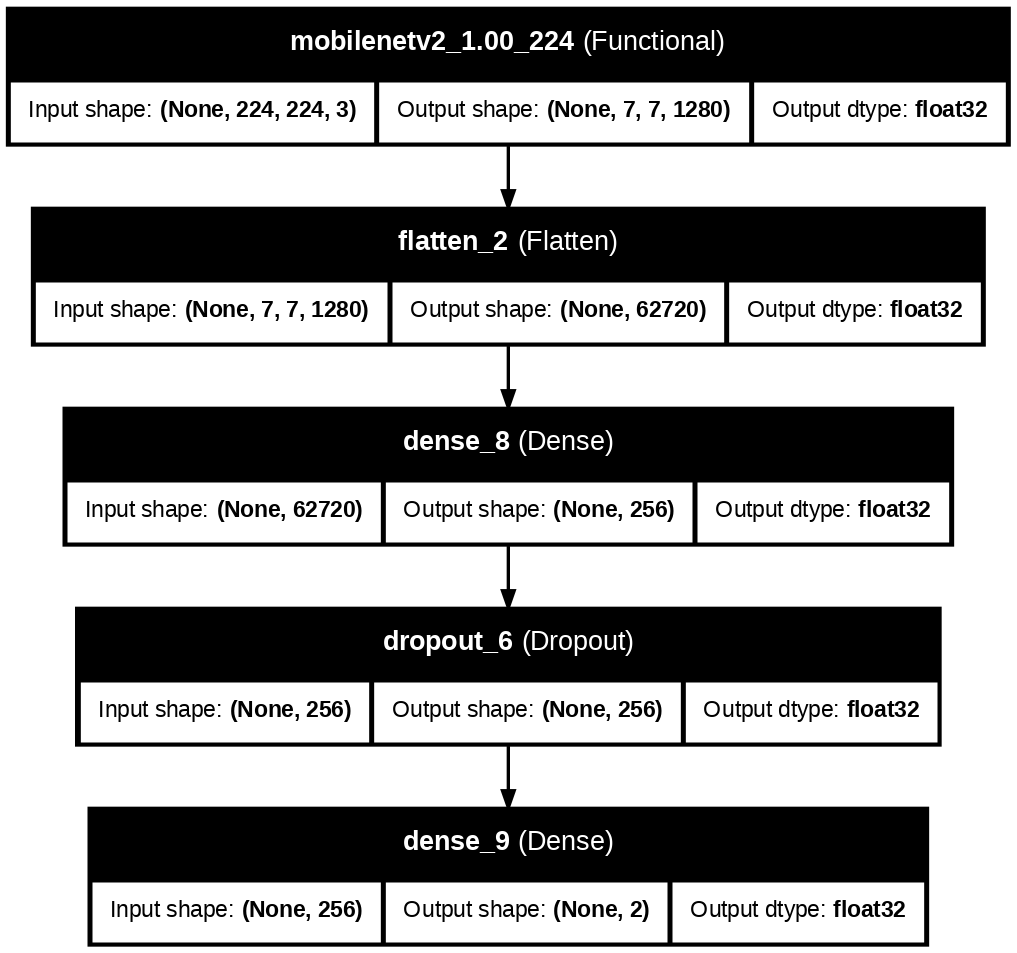

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
checkpoint_cb =ModelCheckpoint("face_model.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_generator, epochs=5, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 8/83 ━━━━━━━━━━━━━━━━━━━━ 16s 218ms/step - accuracy: 0.6094 - loss: 20.7441

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 311ms/step - accuracy: 0.8651 - loss: 5.5175 - val_accuracy: 0.9903 - val_loss: 0.0236
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 214ms/step - accuracy: 0.9939 - loss: 0.0217 - val_accuracy: 0.9894 - val_loss: 0.0185
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - accuracy: 0.9961 - loss: 0.0143 - val_accuracy: 0.9929 - val_loss: 0.0186
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step - accuracy: 0.9976 - loss: 0.0069 - val_accuracy: 0.9868 - val_loss: 0.0390
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/step - accuracy: 0.9984 - loss: 0.0069 - val_accuracy: 0.9938 - val_loss: 0.0189


In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

accuracy      loss  val_accuracy  val_loss
0  0.943257  1.659732      0.990291  0.023617
1  0.993569  0.019592      0.989409  0.018508
2  0.996785  0.012340      0.992939  0.018582
3  0.996785  0.012093      0.986761  0.039013
4  0.997919  0.009574      0.993822  0.018931

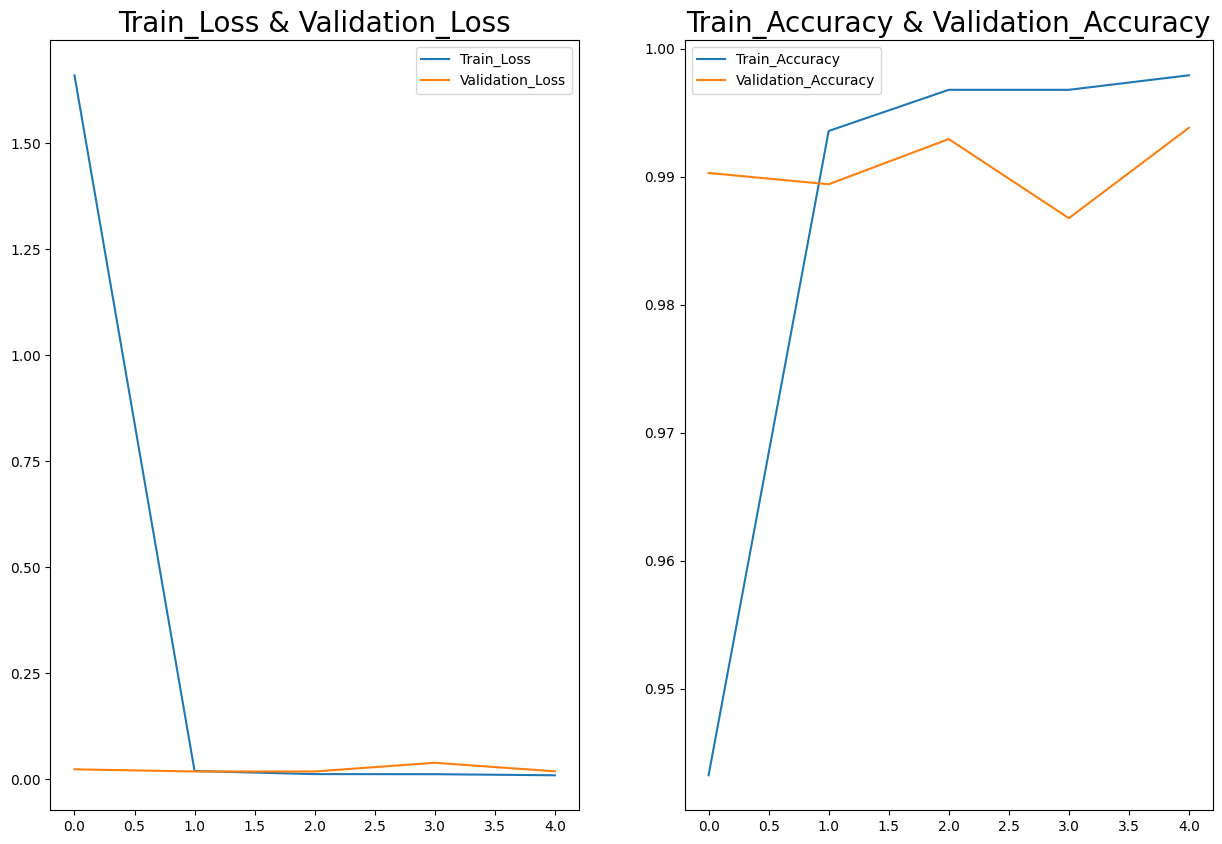

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [ ]:
score, acc= model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)

 1/18 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.9844 - loss: 0.0382

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.9922 - loss: 0.0257
Test Loss = 0.027238305658102036
Test Accuracy = 0.9929391145706177


In [ ]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 340ms/step


Actual  Prediction
0          0           0
1          0           0
2          0           0
3          0           0
4          1           0
...      ...         ...
1128       0           0
1129       1           1
1130       0           0
1131       1           1
1132       0           0

[1133 rows x 2 columns]

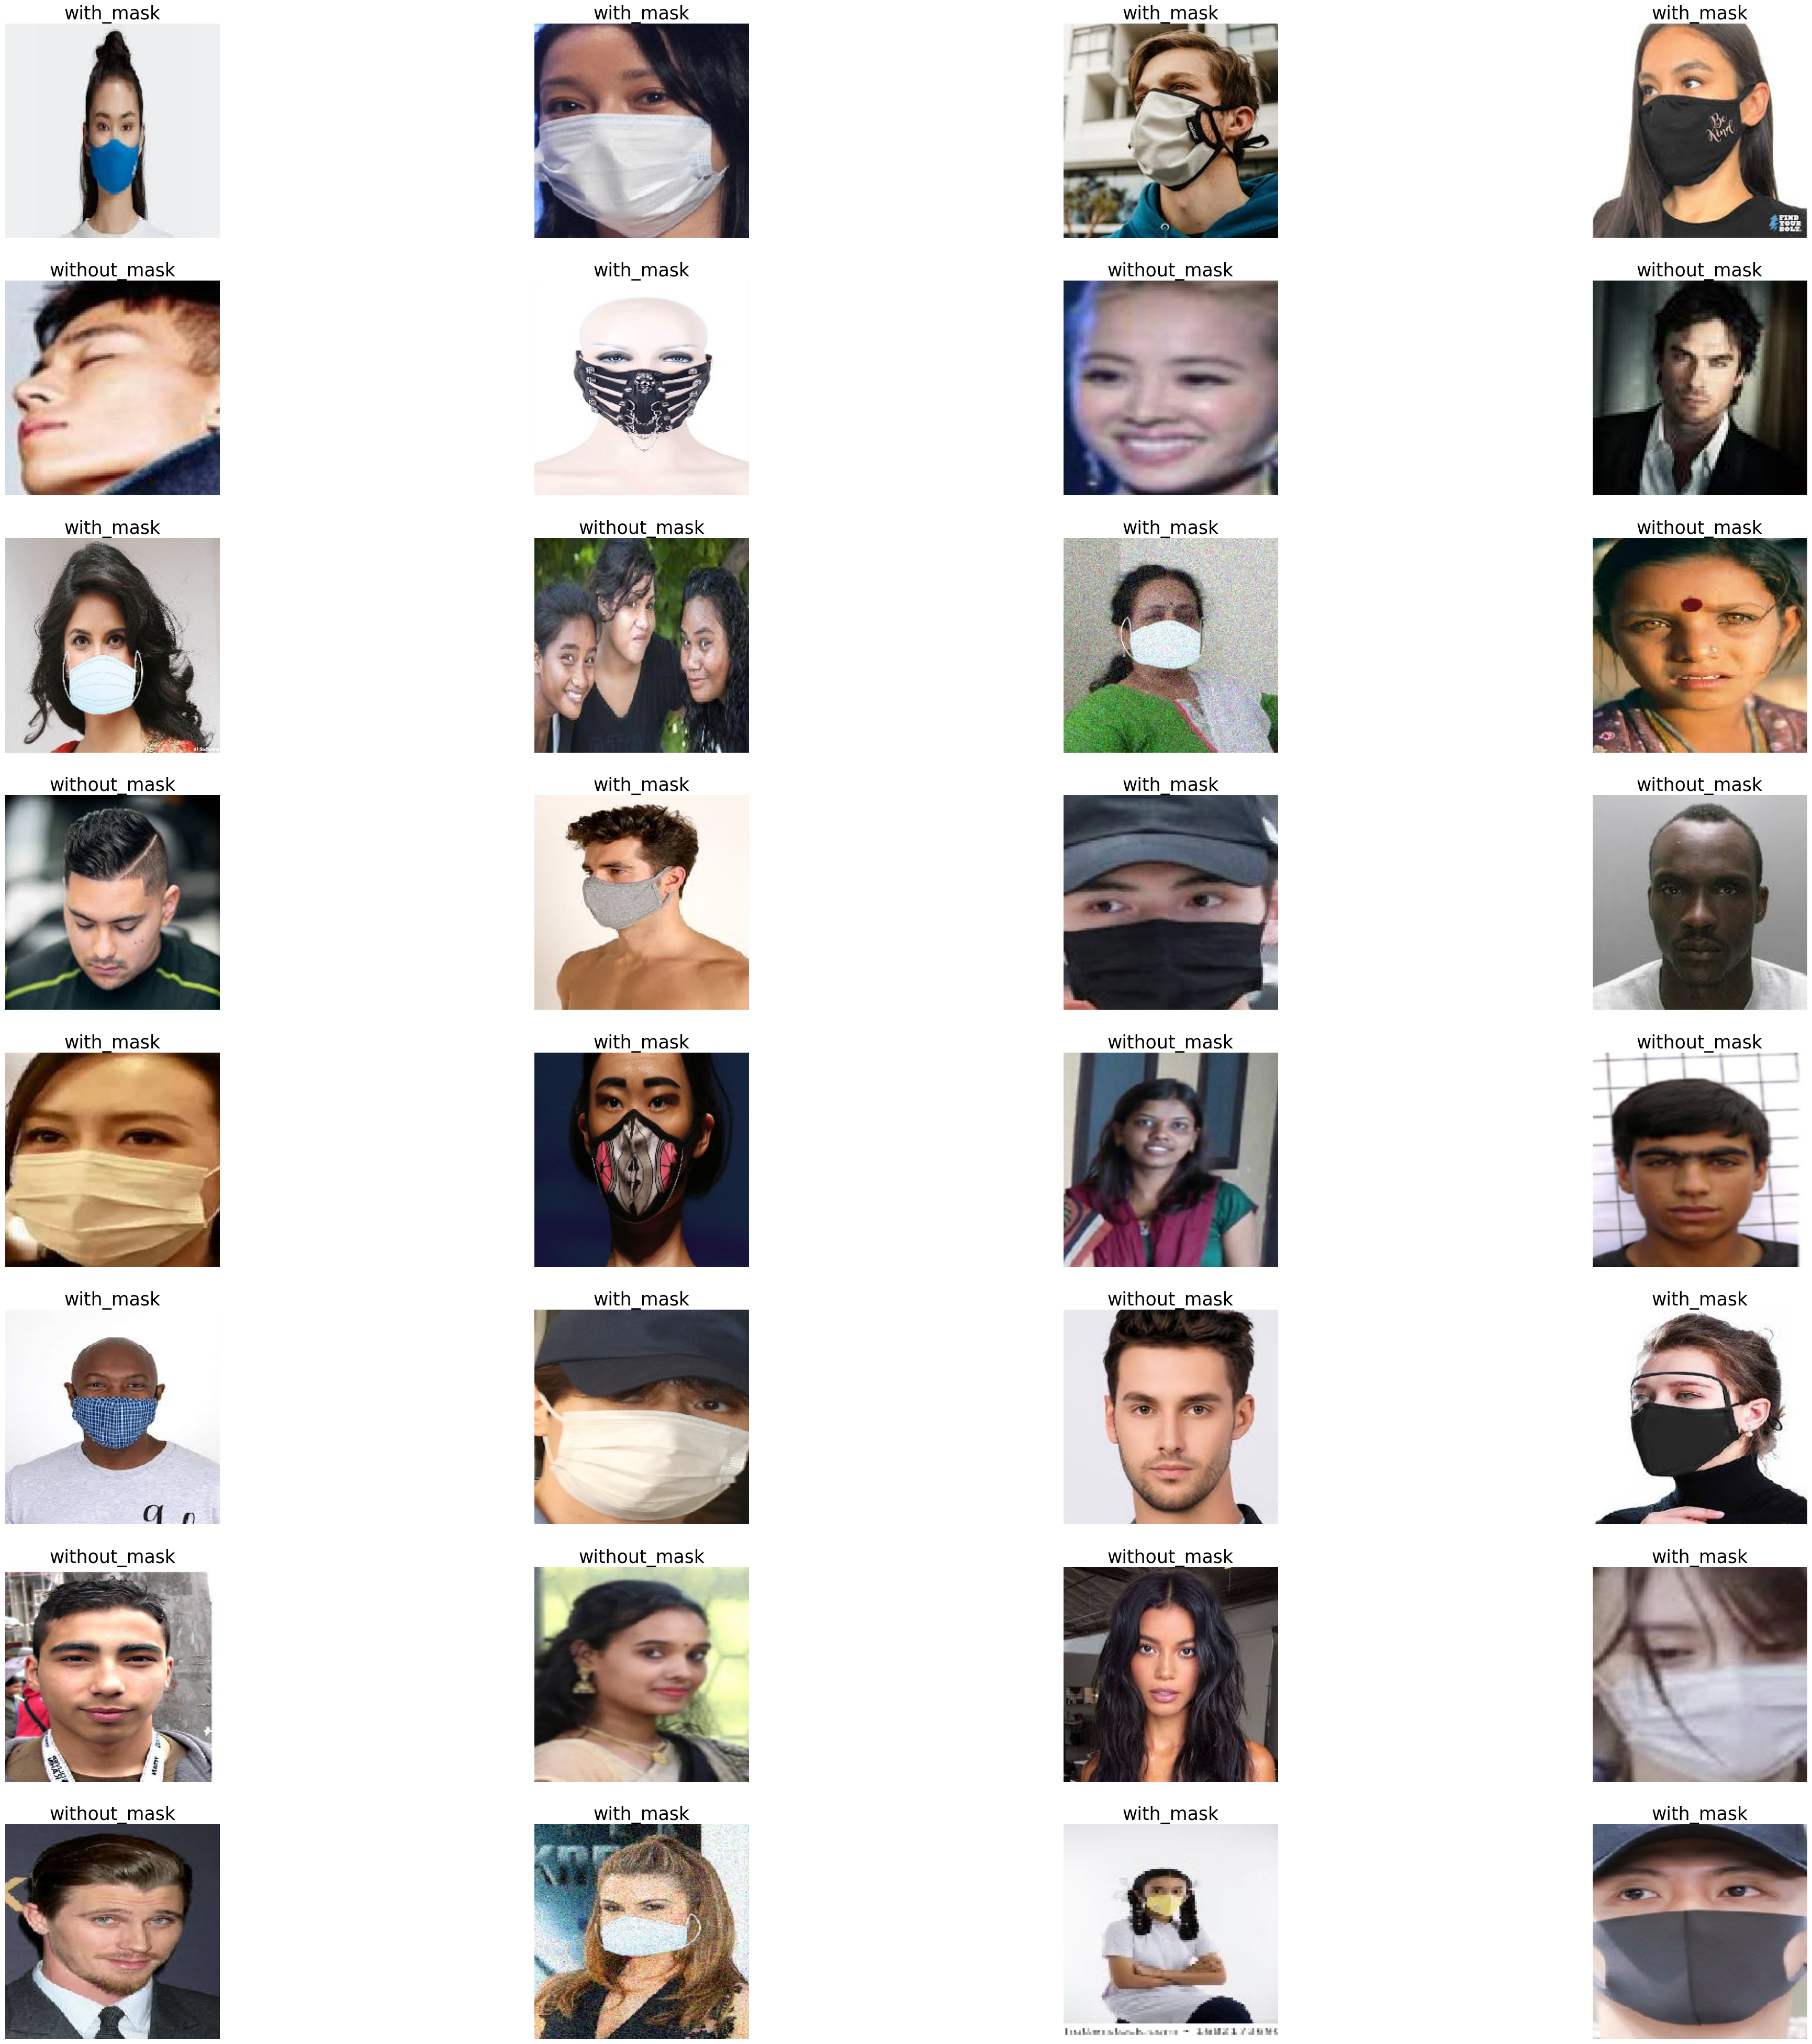

In [ ]:
class_names=['with_mask', 'without_mask']
batch = next(test_generator)
images= batch[0]
plt.figure(figsize=(50,50))
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(class_names[int(y_test[n])],fontsize=25)

array([[555,   4],
       [  4, 570]])

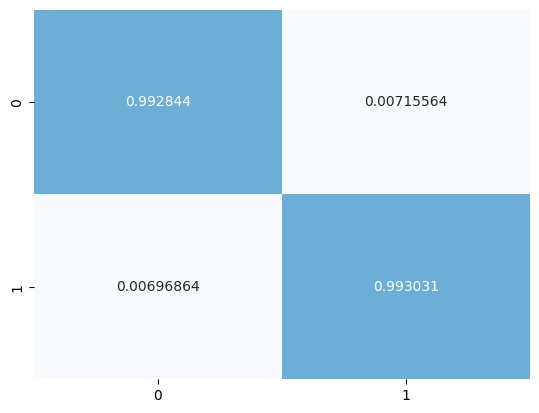

In [ ]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is :',ClassificationReport )

Classification Report is :               precision    recall  f1-score   support

           0       0.99      0.99      0.99       559
           1       0.99      0.99      0.99       574

    accuracy                           0.99      1133
   macro avg       0.99      0.99      0.99      1133
weighted avg       0.99      0.99      0.99      1133



In [ ]:
model.save('/content/model.h5')

MobileNetV2 model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class index for /content/drive/MyDrive/graphic/WhatsApp Image 2024-12-12 at 00.09.51_d755bbf8.jpg: 0
Predicted class name for /content/drive/MyDrive/graphic/WhatsApp Image 2024-12-12 at 00.09.51_d755bbf8.jpg: with_mask


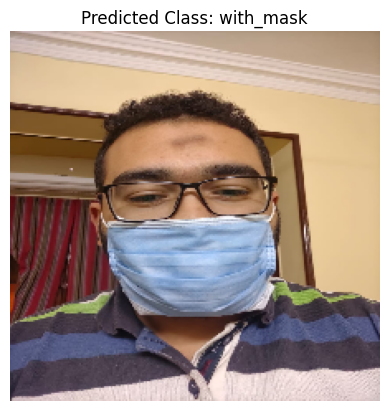

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class index for /content/drive/MyDrive/graphic/WhatsApp Image 2024-12-12 at 00.05.49_439de690.jpg: 1
Predicted class name for /content/drive/MyDrive/graphic/WhatsApp Image 2024-12-12 at 00.05.49_439de690.jpg: without_mask


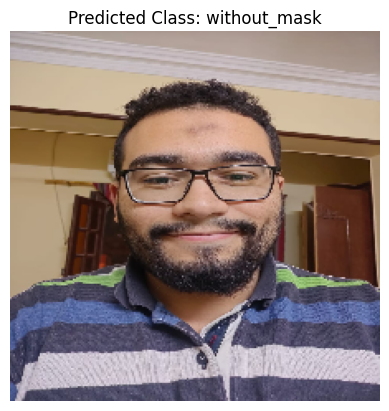

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class index for /content/images.jpg: 1
Predicted class name for /content/images.jpg: without_mask


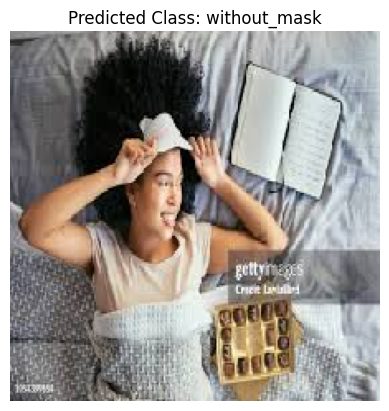

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class index for /content/download.jpg: 1
Predicted class name for /content/download.jpg: without_mask


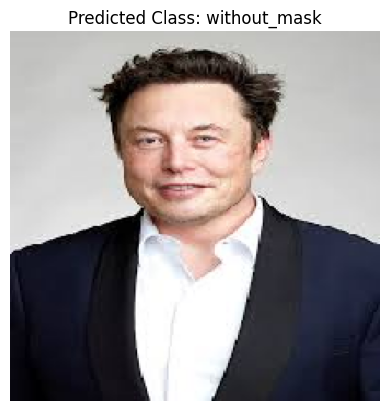

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Load the saved MobileNetV2 model with custom objects (if needed)
model = load_model('/content/model.h5', custom_objects={'softmax_v2': tf.nn.softmax})
print("MobileNetV2 model loaded successfully!")

# List of test image paths (update with your image paths)
test_image_paths = [
    '/content/drive/MyDrive/graphic/WhatsApp Image 2024-12-12 at 00.09.51_d755bbf8.jpg',
    '/content/drive/MyDrive/graphic/WhatsApp Image 2024-12-12 at 00.05.49_439de690.jpg',
    '/content/images.jpg',
    '/content/download.jpg'
]

# Define class labels (update with your actual labels)
class_labels = ['with_mask', 'without_mask']

# Function to process and predict each image
for image_path in test_image_paths:
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))  # Resize to 224x224
    img_array = img_to_array(img)  # Convert to array
    img_array = preprocess_input(img_array)  # Apply MobileNetV2 preprocessing
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict the label of the test image
    predictions = model.predict(img_array)

    # Get the index of the predicted class
    predicted_class = np.argmax(predictions)
    print(f"Predicted class index for {image_path}: {predicted_class}")

    # Map the predicted index to the class name
    predicted_class_name = class_labels[predicted_class]
    print(f"Predicted class name for {image_path}: {predicted_class_name}")

    # Display the test image with the predicted label
    plt.figure()
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class_name}")
    plt.axis('off')
    plt.show()